In [1]:

%load_ext autoreload
%autoreload 2


# Portein
## Portraits of Proteins

Portein plots 3D proteins according to their best 2D projection (best = greatest area visible), allowing for easy automation of protein visualization.

## Quick-start

## Orient your protein

Portein uses some linear algebra (from [1](#2dprojection) and [2](#obb)) to find the best 2D projection for the input protein's 3D coordinates. 

Example usage:

In [2]:
import prody as pd
import portein
import matplotlib.pyplot as plt
portein.compile_numba_functions()

/Users/jay/mambaforge/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/Users/jay/PycharmProjects/test_template/portein/portein/rotate.py:111: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  matrix[:3, 0] = np.dot(quaternion, i)
/Users/jay/PycharmProjects/test_template/portein/portein/rotate.py:111: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  matrix[:3, 0] = np.dot(quaternion, i)
/Users/jay/PycharmProjects/test_template/portein/portein/rotate.py:87: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (a

In [3]:
import yaml
from PIL import Image

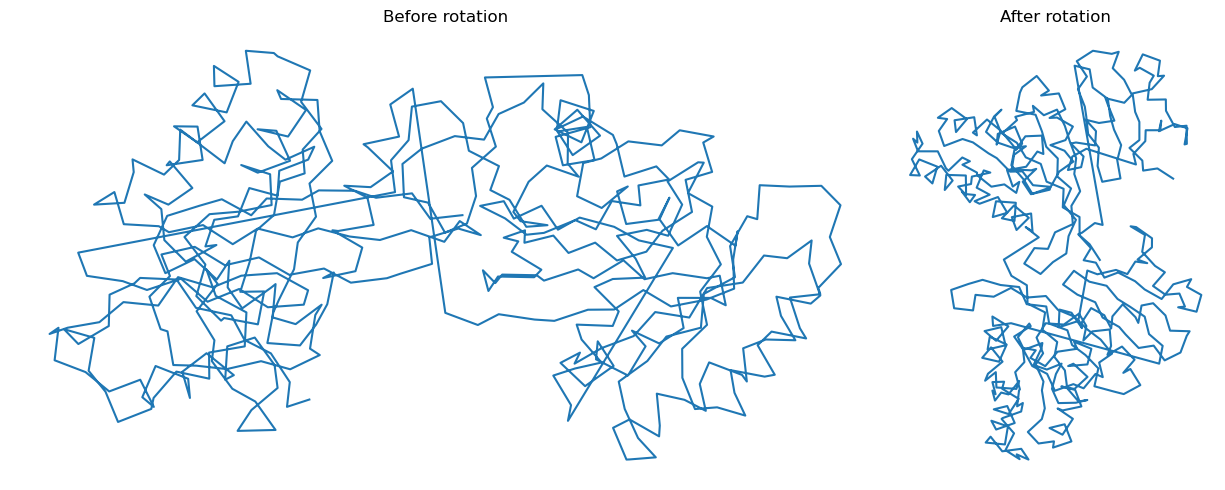

In [26]:
pdb = pd.parsePDB("7lc2")
old_coords = pdb.select("protein and calpha").getCoords()

# Rotate the protein
pdb_oriented = portein.rotate_protein(pdb)
pd.writePDB(f"7lc2_oriented.pdb", pdb_oriented)

new_coords = pdb_oriented.select("protein and calpha").getCoords()
# Find the size of the plot based on the coordinates and a given height (or width)
old_width, old_height = portein.find_size(old_coords, height=5)
new_width, new_height = portein.find_size(new_coords, height=5)

fig, ax = plt.subplots(1, 2, figsize=(old_width + new_width, new_height), gridspec_kw={"width_ratios": [old_width, new_width]})
ax[0].plot(old_coords[:, 0], old_coords[:, 1], "-")
ax[1].plot(new_coords[:, 0], new_coords[:, 1], "-")
ax[0].set_title("Before rotation")
ax[1].set_title("After rotation")
ax[0].axis("off")
ax[1].axis("off")
plt.tight_layout()

## Plot Pymol ray-traced images

This lets you layer different Pymol representations on top of each other, each one ray-traced separately and then combined with user-defined transparencies. All variables that can be set in Pymol can be passed to the `PymolConfig` object.

In [5]:
# Using some default nice PyMOL settings
with open("configs/pymol_settings.yaml") as f:
    pymol_settings = yaml.safe_load(f)
print(pymol_settings)

{'ambient': 0.5, 'antialias': 2, 'cartoon_discrete_colors': True, 'cartoon_fancy_helices': True, 'cartoon_sampling': 20, 'depth_cue': False, 'hash_max': 300, 'light_count': 1, 'ray_opaque_background': False, 'ray_shadows': False, 'ray_texture': 0, 'ray_trace_disco_factor': 1, 'ray_trace_fog': False, 'ray_trace_gain': 0, 'ray_trace_mode': 1, 'specular': False, 'surface_quality': 2}


 Ray: render time: 10.19 sec. = 353.2 frames/hour (16.38 sec. accum.).


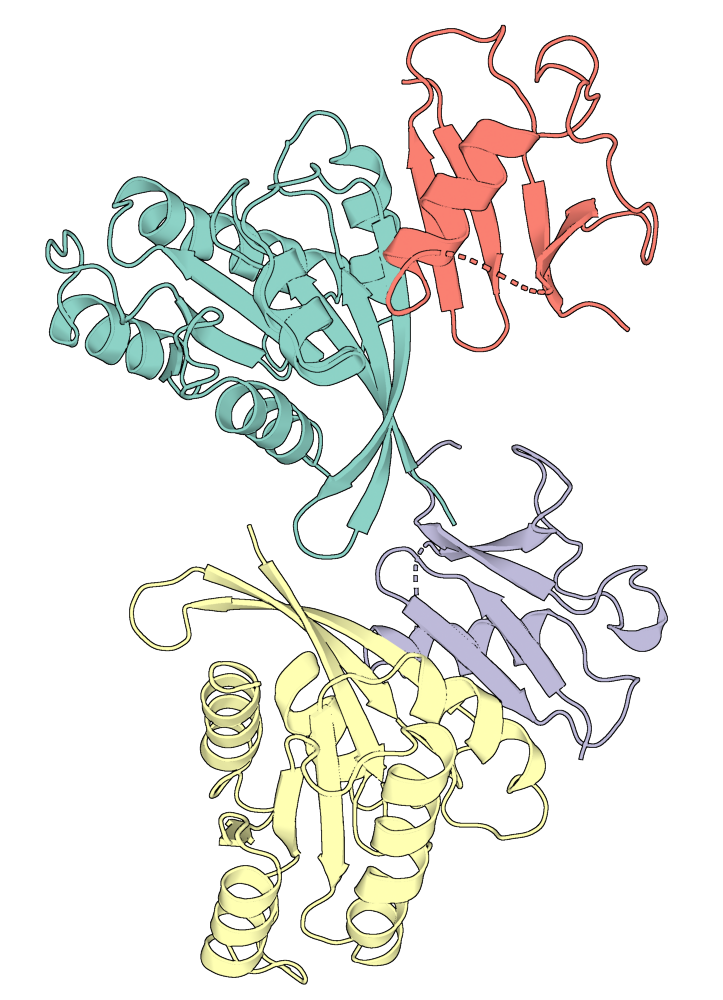

In [6]:
# Set the PDB file and coloring for each chain
protein_config = portein.ProteinConfig(pdb_file="7lc2_oriented.pdb", rotate=False, chain_colormap="Set3", width=1000)

# Single layer of cartoon representation
pymol_config = portein.PymolConfig(layers=[portein.PymolRepresentationConfig(representation="cartoon",
                                                                             pymol_settings=pymol_settings)])

# Run PyMOL
pymol_class = portein.Pymol(protein_config=protein_config, pymol_config=pymol_config)
pymol_class.run()
Image.open(f"7lc2_oriented_pymol.png")

 Ray: render time: 27.43 sec. = 131.3 frames/hour (326.58 sec. accum.).
 Ray: render time: 7.51 sec. = 479.2 frames/hour (341.72 sec. accum.).
 Ray: render time: 0.24 sec. = 15080.0 frames/hour (342.20 sec. accum.).


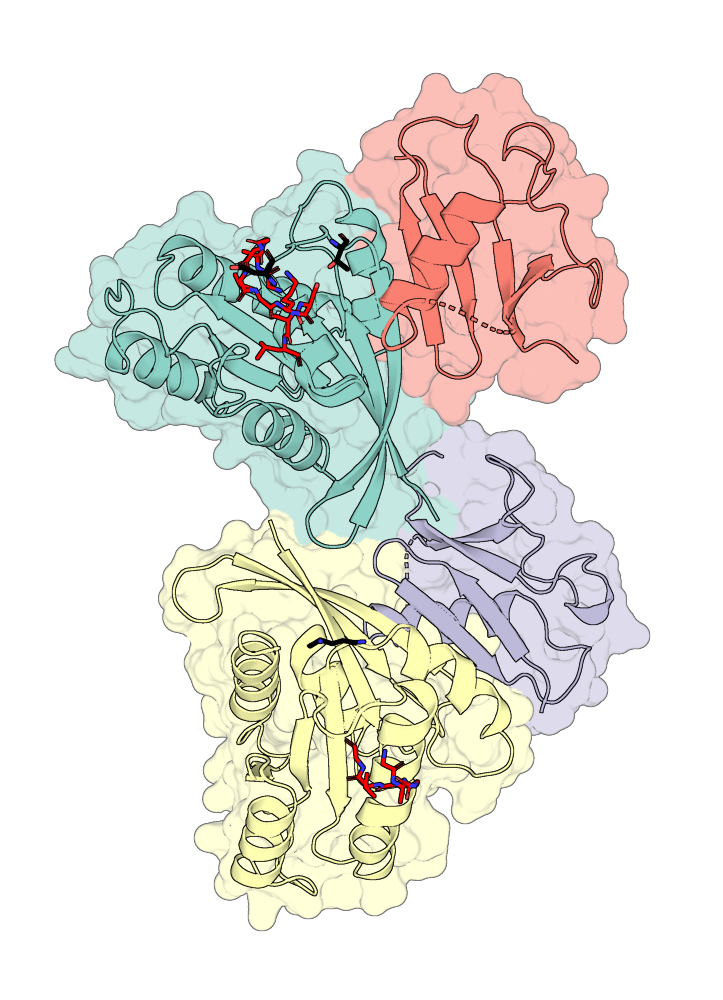

In [9]:
# Fancier version, layer 1 is surface at 0.5 opacity, layer 2 is cartoon and some residues are highlighted

protein_config = portein.ProteinConfig(pdb_file="7lc2_oriented.pdb", rotate=False, output_prefix="7lc2_oriented_fancy",
                                       chain_colormap="Set3", highlight_residues={"A": {"black": [30, 35], "red": list(range(10,20))},
                                                                                  "B": {"black": [25], "red": list(range(10, 16))}},
                                       width=1000)
pymol_config = portein.PymolConfig(layers=[portein.PymolRepresentationConfig(representation="surface",
                                                                             pymol_settings=pymol_settings,
                                                                             transparency=0.5),
                                            portein.PymolRepresentationConfig(representation="cartoon",
                                                                                pymol_settings=pymol_settings),
                                            portein.PymolRepresentationConfig(representation="sticks",
                                                                                pymol_settings=pymol_settings,
                                                                                selection="highlight"),
                                                                        ],
                                    buffer=10)
pymol_class = portein.Pymol(protein_config=protein_config, pymol_config=pymol_config)
pymol_class.run()
Image.open(f"7lc2_oriented_fancy_pymol.png")

## Plot `illustrate` images

Uses David Goodsell's [`illustrate`](https://github.com/ccsb-scripps/Illustrate) to generate images. All `illustrate` parameters are user-definable.

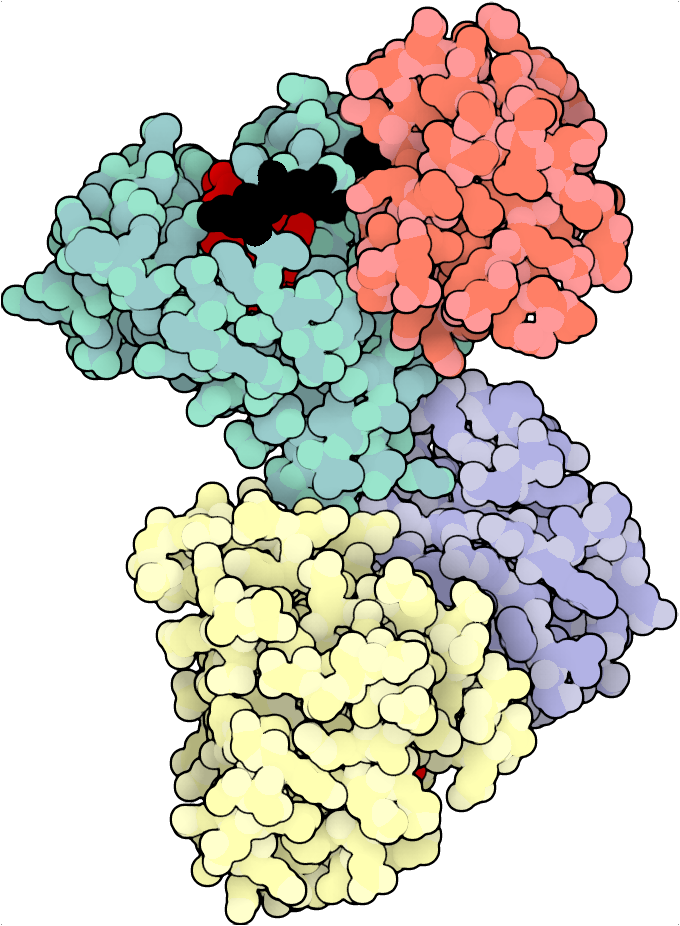

In [15]:
protein_config = portein.ProteinConfig(pdb_file="7lc2_oriented.pdb", rotate=False, output_prefix="7lc2_oriented_fancy",
                                       chain_colormap="Set3", highlight_residues={"A": {"black": [30, 35], "red": list(range(10,20))},
                                                                                  "B": {"black": [25], "red": list(range(10, 16))}},
                                       width=1000)

illustrate = portein.Illustrate(protein_config=protein_config, illustrate_config=portein.IllustrateConfig())
illustrate.run()
Image.open(f"7lc2_oriented_fancy_illustrate.png")

## Plot secondary structure topology diagram

This runs DSSP to split the protein into its secondary structural elements (SSE) and then uses the start and end coordinates of each SSE to plot (adapted from [3](#sseplot1))
* helices as waves or cylinders (controlled by `HelixConfig.as_cylinder`)
* beta sheets as arrows
* turns as arcs with circles at the ends

See the `configs` folder for parameter settings available for each plot type.

<AxesSubplot:>

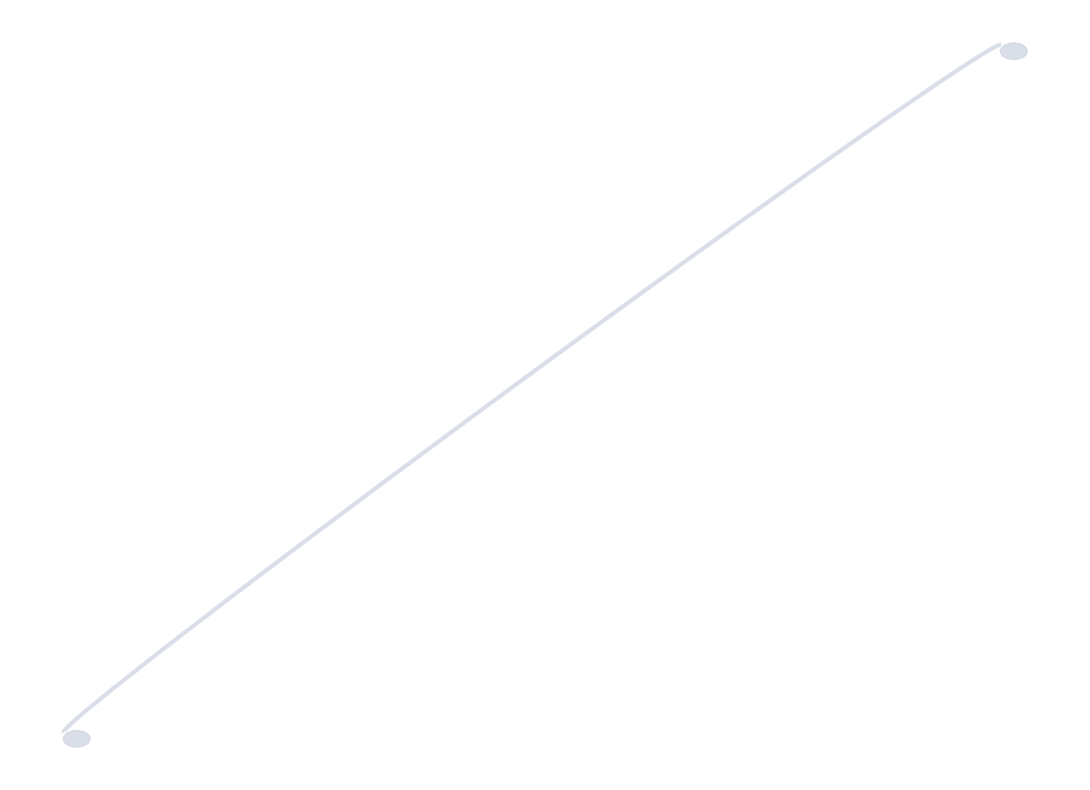

In [42]:
protein_config = portein.ProteinConfig(pdb_file="7lc2_oriented.pdb", rotate=False, height=10)
ss = portein.SecondaryStructure(pdb_file="7lc2.pdb.gz",
                                protein_config=protein_config, 
                                helix_config=portein.HelixConfig(), 
                                sheet_config=portein.SheetConfig(), 
                                turn_config=portein.TurnConfig())
ss.run()

In [50]:
structure = ss.run_dssp()

Dropped unsupported records: TER


<AxesSubplot:>

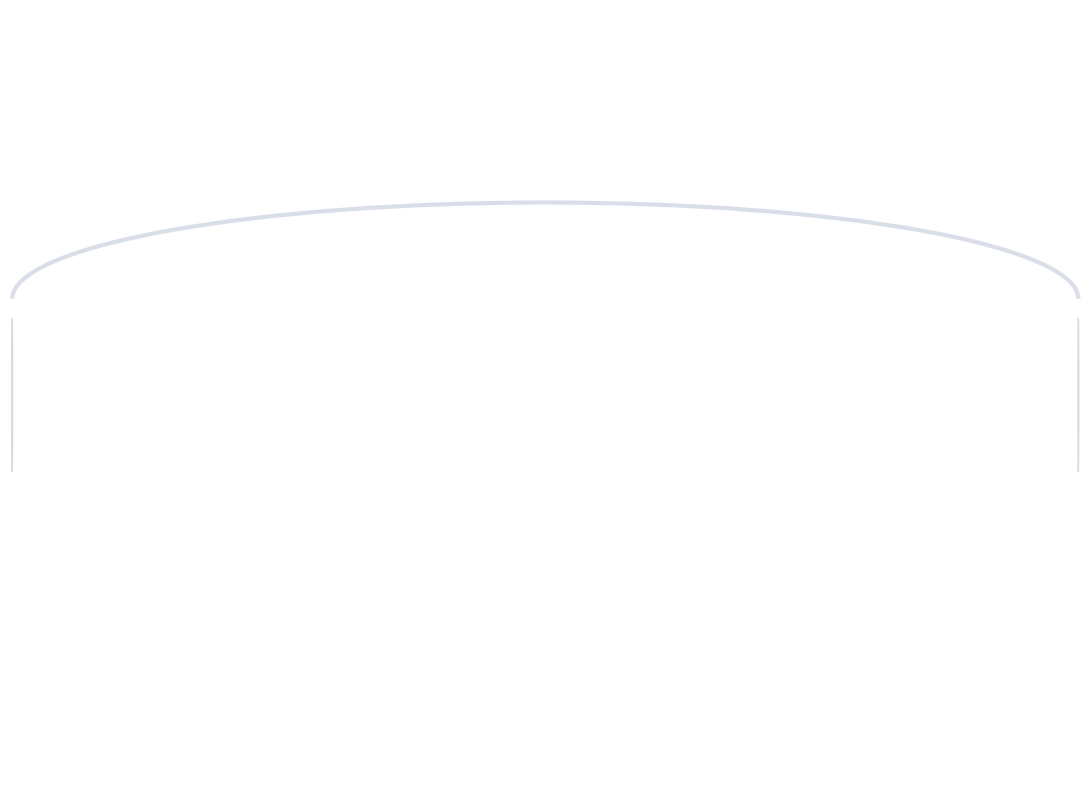

In [28]:
ss.run(linear=True, y_offset=10)